In [ ]:
!gdown --id 1iNBLFXyiS4kiJkPZJb_9-KO-LRYS4Z7V --output audio_wav_especialistas.zip
!unzip audio_wav_especialistas.zip
!rm -rf audio_wav_especialistas.zip

Downloading...
From: https://drive.google.com/uc?id=1iNBLFXyiS4kiJkPZJb_9-KO-LRYS4Z7V
To: /content/audio_wav_especialistas.zip
607MB [00:06, 95.0MB/s]
Archive:  audio_wav_especialistas.zip
   creating: content/audios_expecialistas/
  inflating: content/audios_expecialistas/30fa4631-eba2-44d7-ba44-4ef930092d45.wav  
  inflating: content/audios_expecialistas/9b110ff2-f5c2-4e6e-8bb3-31f502375c7d.wav  
  inflating: content/audios_expecialistas/0b6f8543-c5e3-414c-a4f3-020e56e8ec60.wav  
  inflating: content/audios_expecialistas/c3174535-aaef-4c26-b0b5-a38996e54763.wav  
  inflating: content/audios_expecialistas/46723cf9-49fd-404f-b62f-6ba97019d921.wav  
  inflating: content/audios_expecialistas/2e0e732f-3cf5-4fb6-9762-aae4ab603d4d.wav  
  inflating: content/audios_expecialistas/8debc554-dee0-49c8-8a54-34c26de4190d.wav  
  inflating: content/audios_expecialistas/98e4742a-3aab-4dcb-a5b8-e903f91c4324.wav  
  inflating: content/audios_expecialistas/20638b85-0ab9-45cc-b257-9ce9986946de.wav  
  i

In [ ]:
# Código público extraído de: nn
import numpy as np

#Use old segmentation
def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

def compute_SNR(x, fs):
    """Compute the Signal-to-Noise ratio of the audio signal x (np.array) with sampling frequency fs (float)"""
    segments, cough_mask = segment_cough(x,fs)
    RMS_signal = 0 if len(x[cough_mask])==0 else np.sqrt(np.mean(np.square(x[cough_mask])))
    RMS_noise = np.sqrt(np.mean(np.square(x[~cough_mask])))
    SNR = 0 if (RMS_signal==0 or np.isnan(RMS_noise)) else 20*np.log10(RMS_signal/RMS_noise)
    return SNR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import sys
sys.path.append(os.path.abspath('../src'))

	
# Cough segmentation and SNR computation example
Learn how to use the automatic cough segmentation function. The target signal is comprised of a breath followed by two coughs and a throat-clearing noise. Our goal is to segment each individual cough sound using the segment_cough function, and then compute the SNR of the recording.

Text(0.5, 1.0, 'Input cough signal')

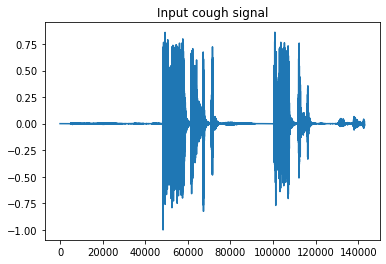

In [ ]:
#Visualize cough signal
file = "/content/content/audios_expecialistas/005b8518-03ba-4bf5-86d2-005541442357.wav"
x,fs = librosa.load(file, sr=None)
plt.plot(x)
plt.title("Input cough signal")

In [ ]:
import IPython.display as ipd
ipd.display(ipd.Audio(data=x, rate=fs))

### Segmentation with default parameters

By default, the minimal cough length (below which segments are discarded) is set to 200ms and the "padding" (extra signal samples before and after each detected cough) is 200ms. These thresholds are based on the physiology of cough sounds but can be adjusted to fit your applications.

Text(0.5, 1.0, 'Segmentation Output')

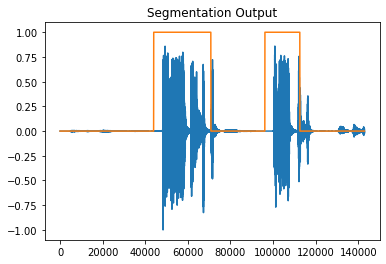

In [ ]:
cough_segments, cough_mask = segment_cough(x,fs)
plt.plot(x)
plt.plot(cough_mask)
plt.title("Segmentation Output")

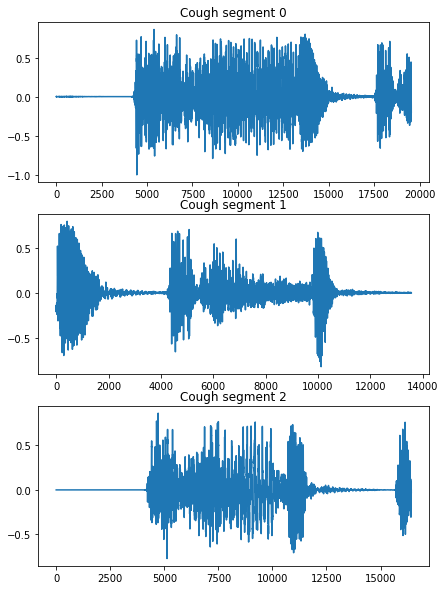

In [ ]:
fig, axs = plt.subplots(len(cough_segments),1, figsize=(7,10))
for i in range(0,len(cough_segments)):
    axs[i].plot(cough_segments[i])
    axs[i].set_title("Cough segment " + str(i))

    ipd.display(ipd.Audio(data=cough_segments[i], rate=fs))
    

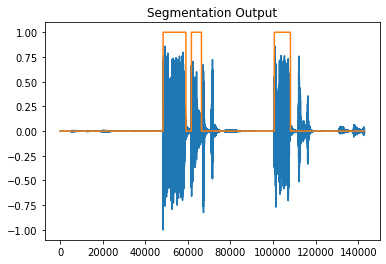

In [ ]:
### Remove extra signal before/after cough
cough_segments, cough_mask = segment_cough(x,fs, cough_padding=0)
plt.plot(x)
plt.plot(cough_mask)
plt.title("Segmentation Output")
ipd.display(ipd.Audio(data=x, rate=fs))

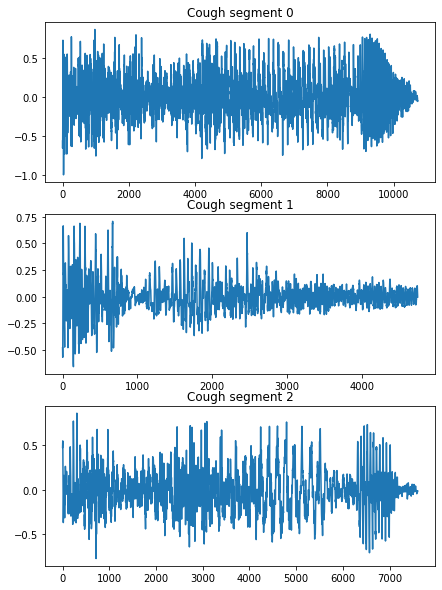

In [ ]:
#We can see that both the breath and the throat-clearning noise at the end are successfully removed.
fig, axs = plt.subplots(len(cough_segments),1, figsize=(7,10))
for i in range(0,len(cough_segments)):
    axs[i].plot(cough_segments[i])
    axs[i].set_title("Cough segment " + str(i))

    ipd.display(ipd.Audio(data=cough_segments[i], rate=fs))

In [ ]:
# APAGAR DEPOIS minha base
file = "/content/content/audios_expecialistas/005b8518-03ba-4bf5-86d2-005541442357.wav"
x,fs = librosa.load(file, sr=None)

#Segmentation with default parameters
cough_segments, cough_mask = segment_cough(x,fs)

#Remove extra signal before/after cough
cough_segments, cough_mask = segment_cough(x,fs, cough_padding=0)

cough_segments[0]

array([-0.5670141 , -0.6589632 , -0.6367694 , ..., -0.05755782,
       -0.06172252, -0.05545163], dtype=float32)

## Processando as bases de áudio: audios_train_especialistas_plus_adicional e audios_train_especialistas

In [ ]:
len(cough_segments)

3

In [ ]:
!gdown --id 1J53C4enur5glM_biw-OSbR4nWEjpFfVe --output audios_train_especialistas.zip
!unzip audios_train_especialistas.zip
!rm -rf audios_train_especialistas.zip

Downloading...
From: https://drive.google.com/uc?id=1J53C4enur5glM_biw-OSbR4nWEjpFfVe
To: /content/audios_train_especialistas.zip
390MB [00:03, 101MB/s]
Archive:  audios_train_especialistas.zip
   creating: content/audios_train_especialistas/
  inflating: content/audios_train_especialistas/18119284-4400-42b1-aa87-883ebdb71cf6.wav  
  inflating: content/audios_train_especialistas/ea454263-90d9-43f6-91d3-a82e80a18781.wav  
  inflating: content/audios_train_especialistas/bb9766af-74b9-4533-ac93-e0d75f7bd7ba.wav  
  inflating: content/audios_train_especialistas/fcb50bad-93f0-4198-96e5-6858c84c5691.wav  
  inflating: content/audios_train_especialistas/a8ca7736-9a4f-4718-954b-eae6047128a3.wav  
  inflating: content/audios_train_especialistas/d6f624cb-757b-441c-bf5f-e22dc914277b.wav  
  inflating: content/audios_train_especialistas/164ff16d-2af8-4724-9a57-3b3bd7e17839.wav  
  inflating: content/audios_train_especialistas/662f6819-1c22-4b25-bd91-d579bb141d49.wav  
  inflating: content/audios_t

In [ ]:
#!gdown --id 1dDVKSRh4B7e-wpL7cvxfOVS57o2-gB2D --output audios_train_especialistas_plus_adicional.zip
#!unzip audios_train_especialistas_plus_adicional.zip
#!rm -rf audios_train_especialistas_plus_adicional.zip

In [ ]:
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

#audio_fpath = "//content/audios_train_especialistas_plus_adicional"
audio_fpath = "/content/content/audios_train_especialistas"
audio_clips = os.listdir(audio_fpath)
print("No. of .wav files in audio folder = ",len(audio_clips))


No. of .wav files in audio folder =  1111


In [ ]:
#audio_clips

In [ ]:
#!rm -rf /content/audios_segmentados_concatenados_especialistas

In [ ]:
#Concatenação dos trechos de tosse
import librosa
import numpy as np
import librosa.display
import soundfile as sf

import glob
import os
from os import listdir
from os.path import isfile, join
import audioread

!mkdir audios_segmentados_concatenados_especialistas
audio_fpath_destinoEspecialista = "/content/audios_segmentados_concatenados_especialistas/"


for i in audio_clips:
#  try:
      x, fs = librosa.load(audio_fpath+'/'+i, sr=None)  

      #Segmentation with default parameters
      cough_segments, cough_mask = segment_cough(x,fs)

      #Remove extra signal before/after cough
      cough_segments, cough_mask = segment_cough(x,fs, cough_padding=0)

      #CONCATENANDO...

      # Eu não sei quantos trechos pode ter 
      print("Quantidade de segmentos: ")
      print(len(cough_segments))

      if (len(cough_segments) > 0):
        print('shape of seg [0] ==> ' + str(cough_segments[0].shape))
        z = cough_segments[0]

        print("y: 0")
        
        # y=0    range=1
        for y in range(len(cough_segments)):
          print("y+1: ")
          print(y+1)

          if (len(cough_segments) > (y+1)): 
            print('shape of seg ==> ' + str(cough_segments[y+1].shape))

            z = np.append(z,cough_segments[y+1])
            print('shape of z ==> ' + str(z.shape))
        
        ipd.display(ipd.Audio(data=z, rate=fs))

        destino_local = audio_fpath_destinoEspecialista+'/'+i
        sf.write(destino_local, data= z, samplerate=fs, subtype='PCM_24')

In [ ]:
!zip -r /content/audios_segmentado_concatenado_especialistas.zip /content/audios_segmentados_concatenados_especialistas

  adding: content/audios_segmentados_concatenados_especialistas/ (stored 0%)
  adding: content/audios_segmentados_concatenados_especialistas/1e3025cb-d921-485b-a08c-c2966fc4f730.wav (deflated 2%)
  adding: content/audios_segmentados_concatenados_especialistas/8ec67d70-2a82-45ea-a646-ab8a5bc4bf4f.wav (deflated 0%)
  adding: content/audios_segmentados_concatenados_especialistas/26abd7b6-569b-41ed-955e-0481ed0368dd.wav (deflated 1%)
  adding: content/audios_segmentados_concatenados_especialistas/b318cffb-62ad-4178-b00f-4fface027263.wav (deflated 0%)
  adding: content/audios_segmentados_concatenados_especialistas/8d33620a-f041-4c6c-b55d-78c1ac9eb8e5.wav (deflated 2%)
  adding: content/audios_segmentados_concatenados_especialistas/feecacb2-52ce-4454-9dcf-267ea138fa63.wav (deflated 0%)
  adding: content/audios_segmentados_concatenados_especialistas/f18bb6f5-90c1-492e-8030-d95acd72b146.wav (deflated 1%)
  adding: content/audios_segmentados_concatenados_especialistas/125243ce-cda2-4412-a38c-47

In [ ]:
from google.colab import files
files.download("/content/audios_segmentado_concatenado_especialistas.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import librosa
import numpy as np
import librosa.display
import soundfile as sf

print('shape of seg [0] ==> ' + str(cough_segments[0].shape))
print('shape of seg [1] ==> ' + str(cough_segments[1].shape))
print('shape of seg [2] ==> ' + str(cough_segments[2].shape))

z = np.append(cough_segments[0],cough_segments[1])
print('shape of [0]+[1] = z ==> ' + str(z.shape))

z = np.append(z,cough_segments[2])
print('shape of z+[2] = z ==> ' + str(z.shape))

ipd.display(ipd.Audio(data=z, rate=fs))

sf.write('joined_file.wav',data=z , samplerate=fs, subtype='PCM_24')

z_loaded, sr = librosa.load('joined_file.wav')
print('shape of z loaded ==> ' + str(z_loaded.shape))

shape of seg [0] ==> (8754,)
shape of seg [1] ==> (11330,)
shape of seg [2] ==> (5020,)
shape of [0]+[1] = z ==> (20084,)
shape of z+[2] = z ==> (25104,)


shape of z loaded ==> (25104,)


	
### Compute SNR of cough signal
Compute an estimate of the SNR by taking the ratio of the power of the cough part of the signal to the ratio of the rest of the signal (i.e. background noise).

In [ ]:
snr = compute_SNR(x,fs)
print("The SNR of the cough signal is {0}".format(snr))

The SNR of the cough signal is 21.83842658996582


In [ ]:
import IPython.display as ipd
ipd.display(ipd.Audio(data=x, rate=fs))